# Import cell
Run the following cell to have all of the required package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import pandas as pd
from datetime import timedelta

%matplotlib inline

# Task 1 Generating the data

In [2]:
def rect(t,A=1,length=1):
    if t <= length:
        return A
    else:
        return 0

In [26]:
# General variables
duration_time = 20 # in minutes
TR = 2 # in sec
time_between_events = 6 # in sec

events = {'Face': {'Amplitude': 1, 'Time_stimulus': 4}, # in sec
          'Control': {'Amplitude': 1/2, 'Time_stimulus': 4}} # in sec

start = pd.to_datetime('00:00:00')

# Create a date range with a TR frequency
date_range = pd.date_range(start=start, end=start+timedelta(minutes=duration_time)-timedelta(seconds=TR), freq=str(TR)+'S')

# Create data to alternate between events
time_events = pd.date_range(start=start, end=start+timedelta(minutes=duration_time)-timedelta(seconds=time_between_events), freq=str(time_between_events)+'S')
list_events = [[list(events)[i % len(events)]] for i in range(len(time_events))]
events_df = pd.DataFrame(data=list_events, index=time_events, columns=["Events"])

# Create signals corresponding to events
bank_of_signals = dict()
for event in events:
    bank_of_signals[event] = []
    for t in range(0, time_between_events, TR):
        bank_of_signals[event].append(rect(t, A=events[event]['Amplitude'], length=events[event]['Time_stimulus']))
    
# Create signals
signal = np.array([])
for event in list_events:
    signal = np.append(signal, bank_of_signals[event[0]]) 
signal = pd.DataFrame(data=signal, index=date_range, columns=["Signal"])

In [27]:
data = pd.concat([signal, events_df], axis=1)
data.loc[data["Events"].isnull(), "Events"] = "Idle"

data.tail(20)

,Signal,Events
2023-10-10 00:19:20,0.5,Idle
2023-10-10 00:19:22,0.5,Idle
2023-10-10 00:19:24,1.0,Face
2023-10-10 00:19:26,1.0,Idle
2023-10-10 00:19:28,1.0,Idle
2023-10-10 00:19:30,0.5,Control
2023-10-10 00:19:32,0.5,Idle
2023-10-10 00:19:34,0.5,Idle
2023-10-10 00:19:36,1.0,Face
2023-10-10 00:19:38,1.0,Idle


Text(0, 0.5, 'Signal')

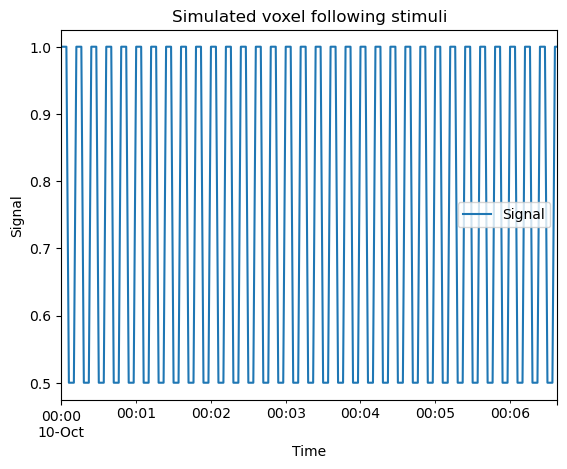

In [28]:
data.iloc[:200].plot()
plt.title("Simulated voxel following stimuli")
plt.xlabel("Time")
plt.ylabel("Signal")

# Task 2
Define the HRF. From course 2.1 slide 7, the HRF is the impulse response of $h_{\delta}$, and from the project file, we have $ h_{\gamma} = A ( \frac{t^{\alpha _1 -1} \beta _1^{\alpha_1} e^{\beta _1 t} }{\Gamma (\alpha _1)} -c \frac{t^{\alpha _2 -1} \beta _2^{\alpha_2} e^{\beta _2 t}}{\Gamma (\alpha _2)})$

with $\alpha_1 = 6$, $\alpha_2 = 16$, $\beta_1 = \beta_2 = 1$ and $c=⅙$

In [29]:
def h(A, t, alpha_1=6, alpha_2=16):
    beta_1 = 1
    beta_2 = 1
    c = 1/6
    
    h_part_1 = gamma.pdf(t, alpha_1, scale=1/beta_1)
    h_part_2 = c * gamma.pdf(t, alpha_2, scale=1/beta_2)
    h = A*(h_part_1 -h_part_2)
    
    return h

Text(0, 0.5, 'Amplitude')

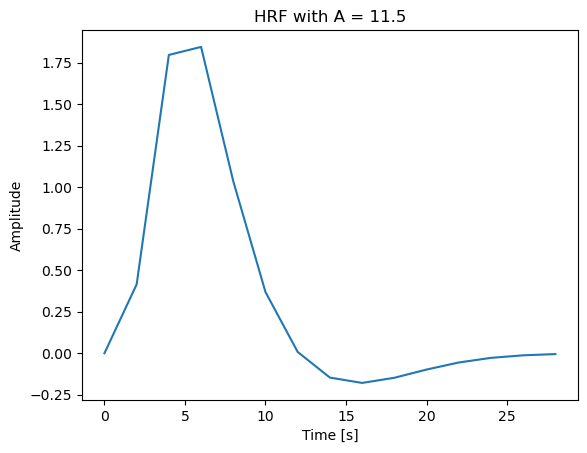

In [30]:
# Define our hrf
A = 11.5
time_len = 30


hrf = h(A, range(0, time_len, TR))
plt.plot(range(0, time_len, TR), hrf)
plt.title("HRF with A = {}".format(A))
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

Text(0.5, 1.0, 'Part of the convolved signal')

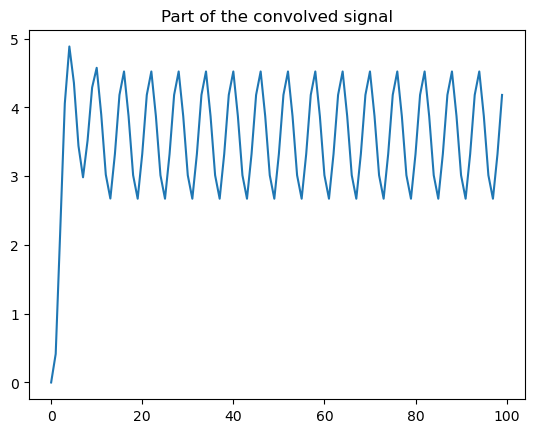

In [31]:
convolved_signal = np.convolve(hrf, data["Signal"])#, mode='same')
plt.plot(convolved_signal[:100])
plt.title('Part of the convolved signal')

# Task 3

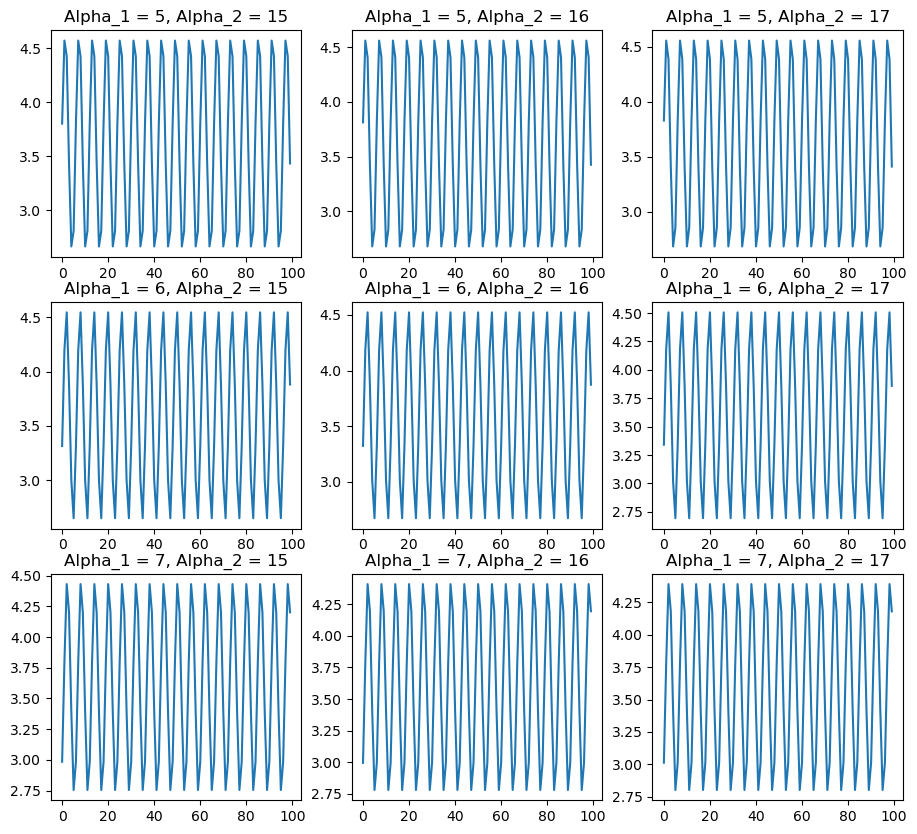

In [32]:
# Let's try to change the alphas

alpha_1_values = range(5, 8)
alpha_2_values = range(15, 18)

fig, axes = plt.subplots(3, 3, figsize=(11,10))

for i, alpha1 in enumerate(alpha_1_values):
    for j, alpha2 in enumerate(alpha_2_values):
        ax = axes[i, j]
        
        hrf2 = h(A, range(0, time_len, TR), alpha_1=alpha1, alpha_2=alpha2)
        convolved_signal2 = np.convolve(hrf2, data["Signal"], mode='valid')
        
        ax.plot(convolved_signal2[:100])
        ax.set_title('Alpha_1 = {}, Alpha_2 = {}'.format(alpha1, alpha2))

# Task 4

Text(0.5, 1.0, 'Plots of the responses along with some noise')

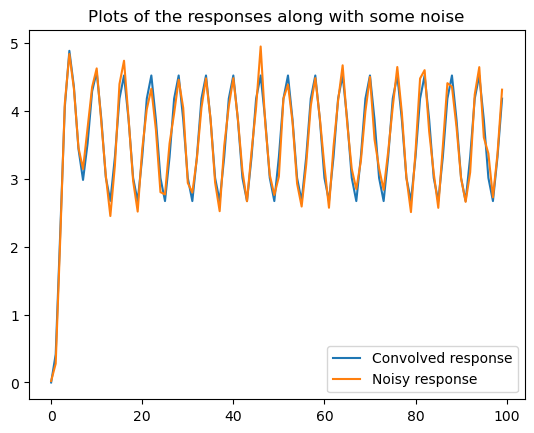

In [33]:
sigma = 0.15
noisy_response = convolved_signal + np.random.normal(scale=sigma, size=len(convolved_signal))
plt.plot(convolved_signal[:100], label='Convolved response')
plt.plot(noisy_response[:100], label='Noisy response')
plt.legend()
plt.title('Plots of the responses along with some noise')

# Task 5

# Attempt to task 9

In [12]:
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [ ]:
# Create directories
sample_path = "dataset"
dataset_id = 'ds000105'
subject = '1'

mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

In [13]:
os.system("""openneuro-py download --dataset {} --include sub-{}/anat/* 
          --include sub-{}/func/sub-{}_task-objectviewing_run-01_bold.nii.gz 
          --include sub-{}/func/sub-{}_task-objectviewing_run-01_events.tsv
          --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))

NameError: name 'dataset_id' is not defined

In [ ]:
reset_overlays()
load(op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_bold.nii.gz'))

In [ ]:
events_sub1 = pd.read_csv(op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_events.tsv'), sep='\t')

In [20]:
events_sub1

,onset,duration,trial_type
0,12.0,0.5,scissors
1,14.0,0.5,scissors
2,16.0,0.5,scissors
3,18.0,0.5,scissors
4,20.0,0.5,scissors
...,...,...,...
91,278.0,0.5,chair
92,280.0,0.5,chair
93,282.0,0.5,chair
94,284.0,0.5,chair
